In [ ]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [ ]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [ ]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


<Axes: ylabel='ocean_proximity'>

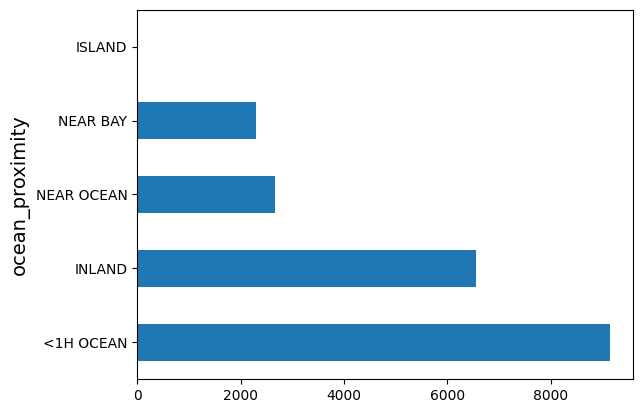

In [ ]:
housing["ocean_proximity"].value_counts().plot(kind="barh")

In [ ]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [ ]:
IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

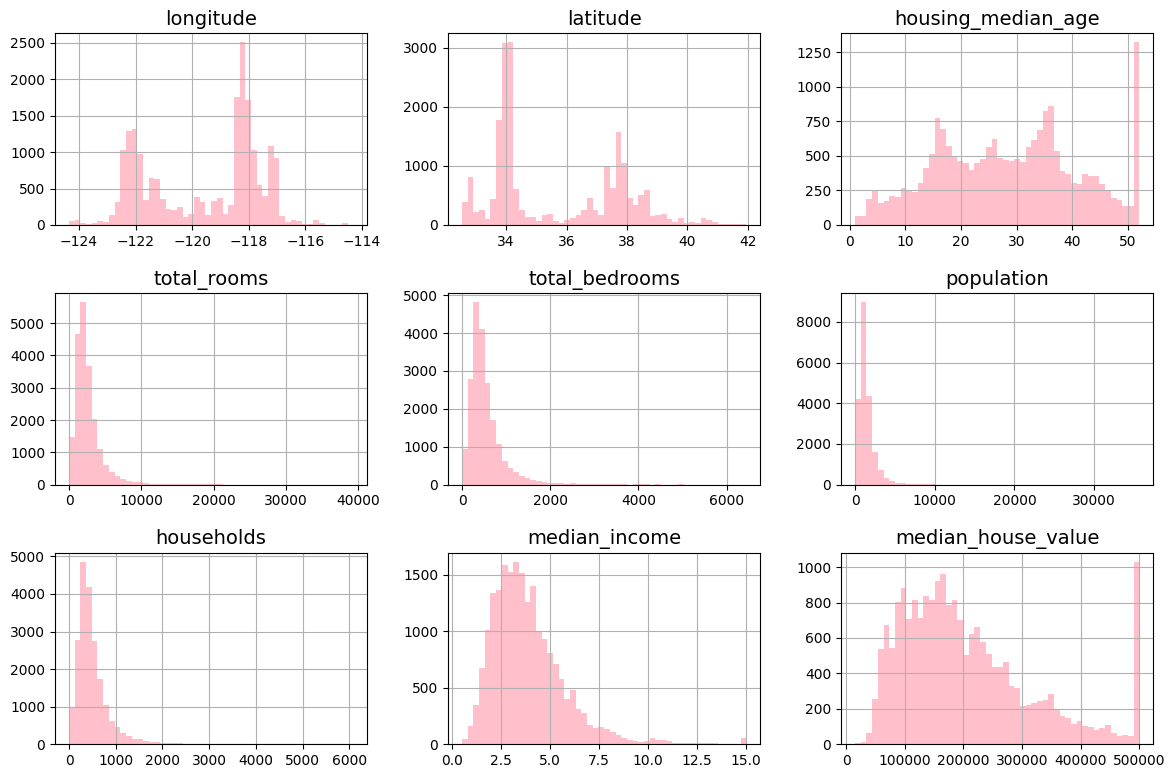

In [ ]:
import matplotlib.pyplot as plt


plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize=(12, 8), color='pink')
save_fig("attribute_histogram_plots")
plt.show()


In [ ]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]
train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(train_set)

16512

In [ ]:
np.random.seed(42)

In [ ]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]
housing_with_id = housing.reset_index()  # adds an `index` column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
test_set["total_bedrooms"].isnull().sum()

44

In [ ]:
from scipy.stats import binom

sample_size = 1000
ratio_female = 0.511
proba_too_small = binom(sample_size, ratio_female).cdf(485 - 1)
proba_too_large = 1 - binom(sample_size, ratio_female).cdf(535)
print(proba_too_small + proba_too_large)

0.10736798530929942


In [ ]:
np.random.seed(42)

samples = (np.random.rand(100_000, sample_size) < ratio_female).sum(axis=1)
((samples < 485) | (samples > 535)).mean()

0.1071

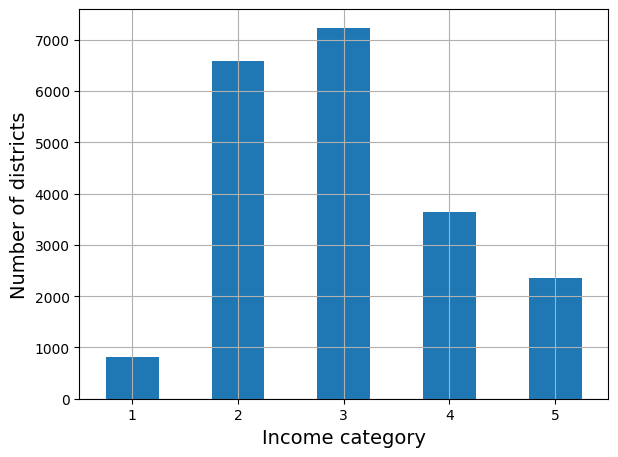

In [ ]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
save_fig("housing_income_cat_bar_plot")  # extra code
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])
strat_train_set, strat_test_set = strat_splits[0]

In [ ]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [ ]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


In [ ]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [ ]:
housing = strat_train_set.copy()

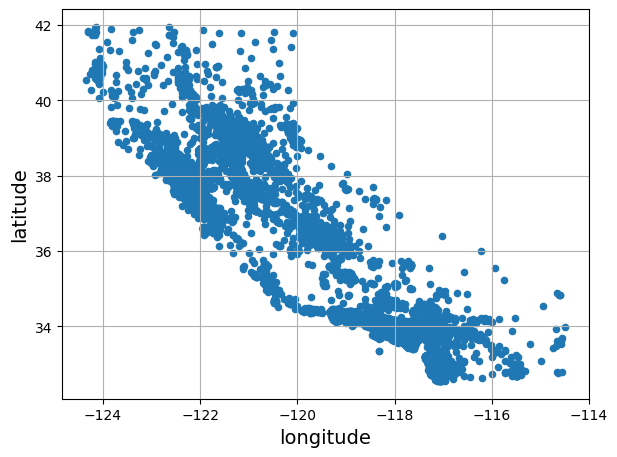

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
save_fig("bad_visualization_plot")  # extra code
plt.show()

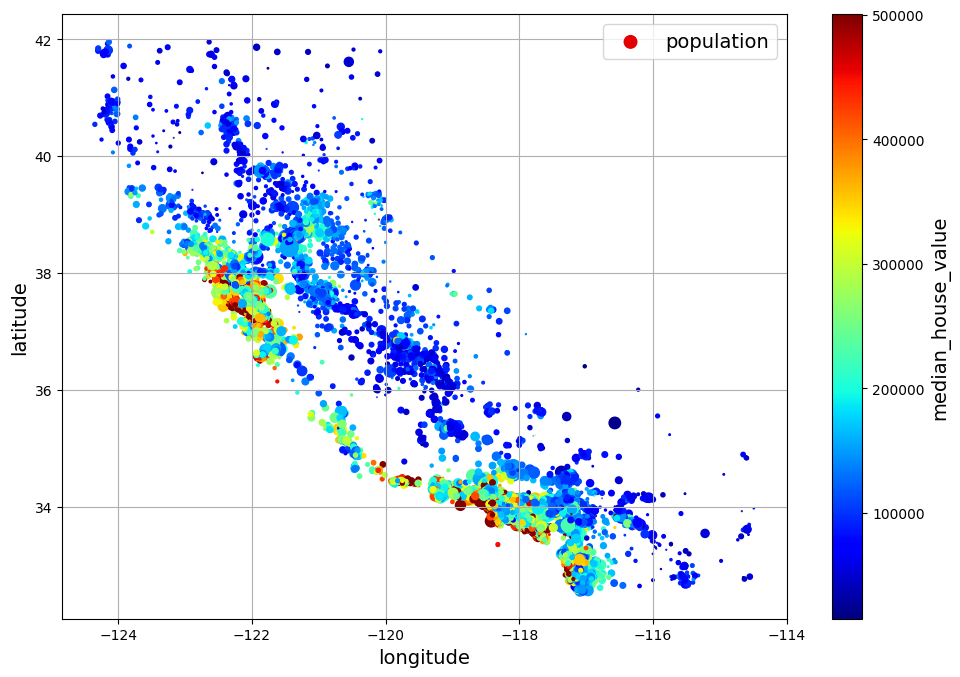

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
save_fig("housing_prices_scatterplot")  # extra code
plt.show()

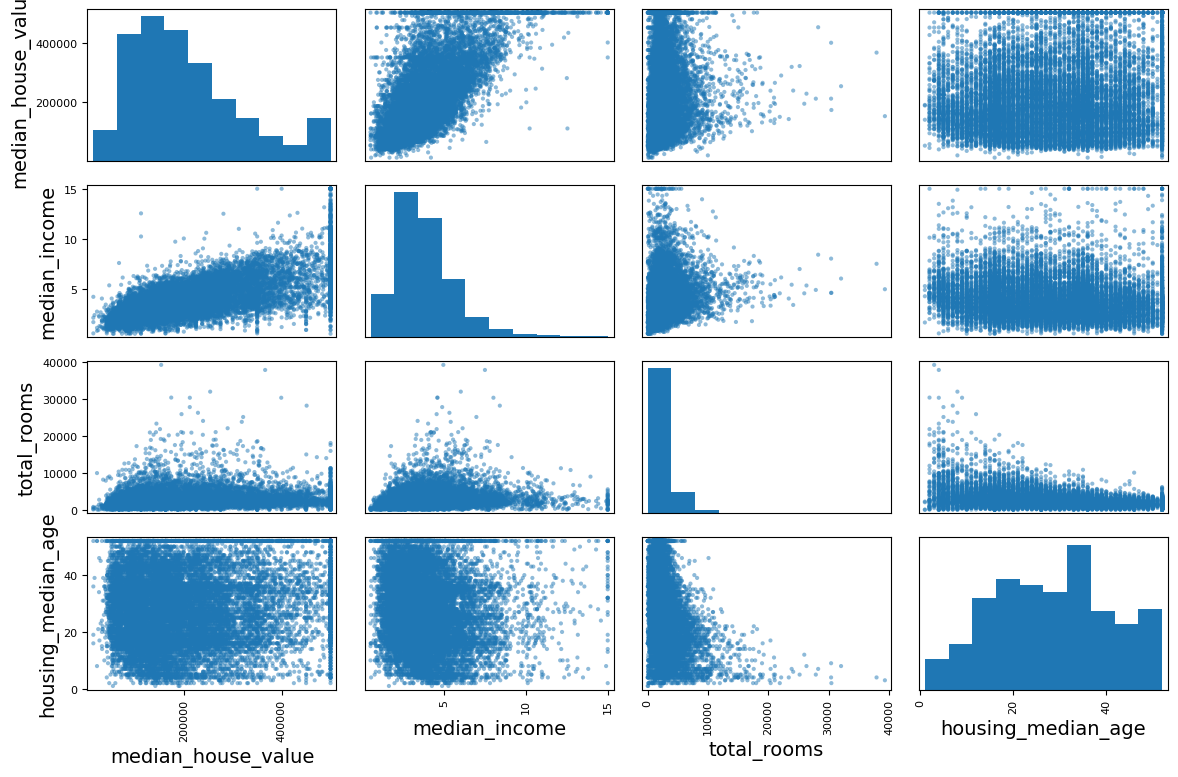

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")  # extra code
plt.show()

In [ ]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

In [ ]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [ ]:
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [ ]:
housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [ ]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [ ]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [ ]:
X = imputer.transform(housing_num)
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)
housing_tr.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


In [ ]:
imputer.strategy

housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)
housing_tr.loc[null_rows_idx].head()  # not shown in the boo

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


In [ ]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)
outlier_pred

array([-1,  1,  1, ...,  1,  1,  1])

In [ ]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)


,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [ ]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [ ]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [ ]:
cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot


array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [ ]:
cat_encoder.categories_
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)
cat_encoder.transform(df_test)
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown)
cat_encoder.feature_names_in_
cat_encoder.get_feature_names_out()
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown),
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


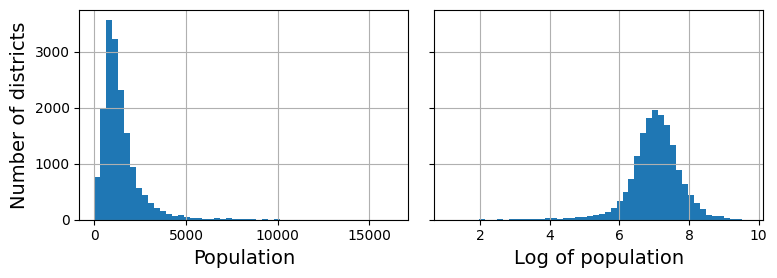

In [ ]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)
# extra code – this cell generates Figure 2–17
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
save_fig("long_tail_plot")
plt.show()

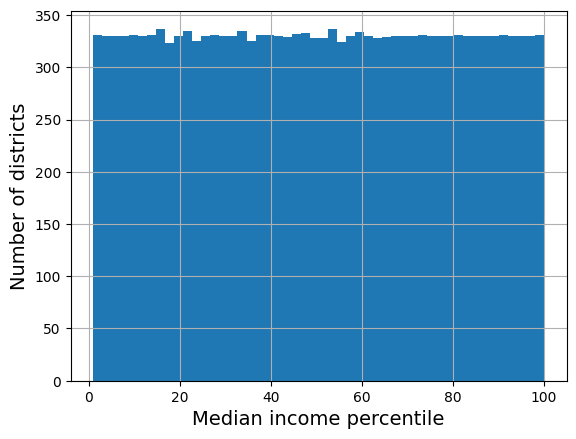

In [ ]:
percentiles = [np.percentile(housing["median_income"], p)
               for p in range(1, 100)]
flattened_median_income = pd.cut(housing["median_income"],
                                 bins=[-np.inf] + percentiles + [np.inf],
                                 labels=range(1, 100 + 1))
flattened_median_income.hist(bins=50)
plt.xlabel("Median income percentile")
plt.ylabel("Number of districts")
plt.show()

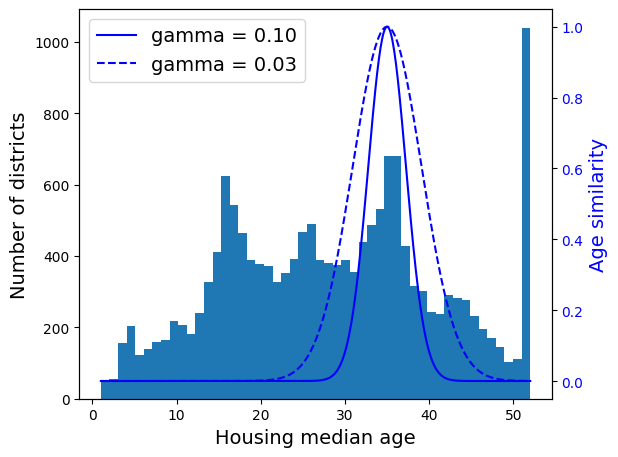

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)
# extra code – this cell generates Figure 2–18

ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")
save_fig("age_similarity_plot")
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]  # pretend this is new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)
predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

In [ ]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)
predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

In [ ]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])
rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])
age_simil_35

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]])

In [ ]:
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])
sf_simil
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y is required even though we don't use it
        X = check_array(X)  # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

In [ ]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [ ]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_labels)
similarities[:3].round(2)

array([[0.  , 0.14, 0.  , 0.  , 0.  , 0.08, 0.  , 0.99, 0.  , 0.6 ],
       [0.63, 0.  , 0.99, 0.  , 0.  , 0.  , 0.04, 0.  , 0.11, 0.  ],
       [0.  , 0.29, 0.  , 0.  , 0.01, 0.44, 0.  , 0.7 , 0.  , 0.3 ]])

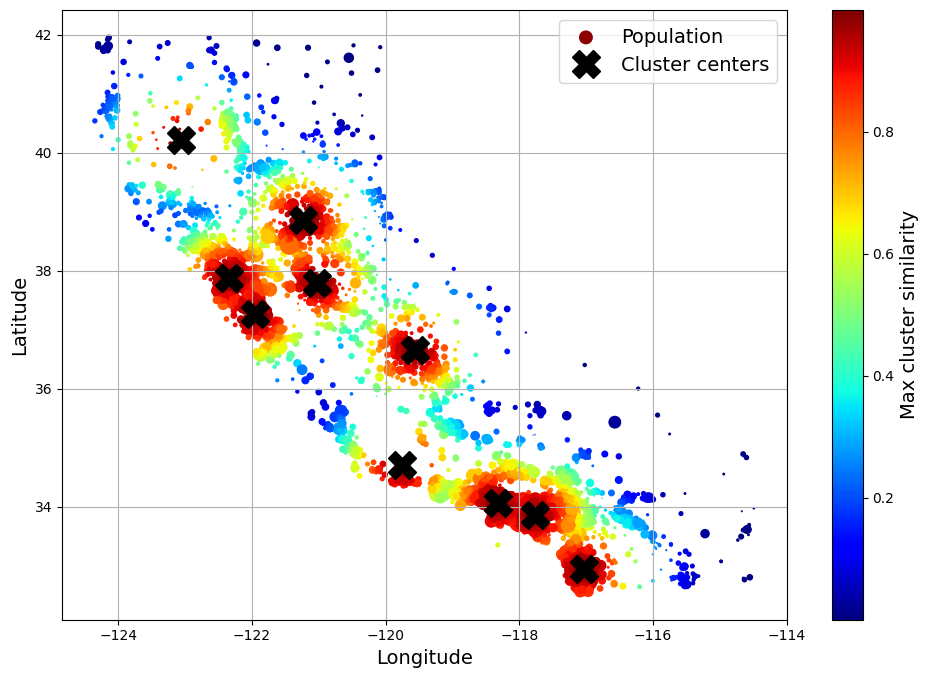

In [ ]:
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
save_fig("district_cluster_plot")
plt.show()

In [ ]:
# Use Isolation Forest to identify outliers
iso_forest = IsolationForest(contamination=0.1, random_state=42)
outliers = iso_forest.fit_predict(X_scaled)
mask = outliers != -1

# Filter out the outliers
X_filtered = X_scaled[mask]
y_filtered = y[mask]

In [ ]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
from sklearn import set_config

set_config(display='diagram')

num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [ ]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [ ]:
def monkey_patch_get_signature_names_out():
    """Monkey patch some classes which did not handle get_feature_names_out()
       correctly in Scikit-Learn 1.0.*."""
    from inspect import Signature, signature, Parameter
    import pandas as pd
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import make_pipeline, Pipeline
    from sklearn.preprocessing import FunctionTransformer, StandardScaler

    default_get_feature_names_out = StandardScaler.get_feature_names_out

    if not hasattr(SimpleImputer, "get_feature_names_out"):
      print("Monkey-patching SimpleImputer.get_feature_names_out()")
      SimpleImputer.get_feature_names_out = default_get_feature_names_out

    if not hasattr(FunctionTransformer, "get_feature_names_out"):
        print("Monkey-patching FunctionTransformer.get_feature_names_out()")
        orig_init = FunctionTransformer.__init__
        orig_sig = signature(orig_init)

        def __init__(*args, feature_names_out=None, **kwargs):
            orig_sig.bind(*args, **kwargs)
            orig_init(*args, **kwargs)
            args[0].feature_names_out = feature_names_out

        __init__.__signature__ = Signature(
            list(signature(orig_init).parameters.values()) + [
                Parameter("feature_names_out", Parameter.KEYWORD_ONLY)])
        def get_feature_names_out(self, names=None):
            if callable(self.feature_names_out):
                return self.feature_names_out(self, names)
            assert self.feature_names_out == "one-to-one"
            return default_get_feature_names_out(self, names)

        FunctionTransformer.__init__ = __init__
        FunctionTransformer.get_feature_names_out = get_feature_names_out

monkey_patch_get_signature_names_out()

In [ ]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index)

In [ ]:
num_pipeline.steps

[('simpleimputer', SimpleImputer(strategy='median')),
 ('standardscaler', StandardScaler())]

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

In [ ]:
housing_prepared = preprocessing.fit_transform(housing)
# extra code – shows that we can get a DataFrame out if we want
housing_prepared_fr = pd.DataFrame(
    housing_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=housing.index)
housing_prepared_fr.head(2)

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,0.0,0.0,0.0,1.0,0.0
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,1.0,0.0,0.0,0.0,0.0


In [ ]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # o

In [ ]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 24)

In [ ]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7a7...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7a7bd990f6a0>)])),
                ('linearregression', LinearRegression())])

In [ ]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)

array([243700., 372400., 128800.,  94400., 328300.])

In [ ]:
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

In [ ]:
error_ratios = housing_predictions[:5].round(-2) / housing_labels.iloc[:5].values - 1
print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

-46.8%, -23.0%, 26.6%, -1.8%, -9.3%


In [ ]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)
lin_rmse

68687.89176590038

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7a7...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7a7bd990f6a0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [ ]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)
tree_rmse

0.0

In [ ]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)

In [ ]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     66868.027288
std       2060.966425
min      63649.536493
25%      65338.078316
50%      66801.953094
75%      68229.934454
max      70094.778246
dtype: float64

In [ ]:
lin_rmses = -cross_val_score(lin_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

count       10.000000
mean     69858.018195
std       4182.205077
min      65397.780144
25%      68070.536263
50%      68619.737842
75%      69810.076342
max      80959.348171
dtype: float64

In [ ]:
forest_reg.fit(housing, housing_labels)
housing_predictions = forest_reg.predict(housing)
forest_rmse = mean_squared_error(housing_labels, housing_predictions,
                                 squared=False)
forest_rmse

17474.619286483998

In [ ]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [ ]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7a7be4b...
                                                  ClusterSimilarity(n_clusters=15,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7a7bb50a9fc0>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

In [ ]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

# extra code – these few lines of code just make the DataFrame look nicer
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()


,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,43460,43919,44748,44042
13,15,8,44132,44075,45010,44406
14,15,10,44374,44286,45316,44659
7,10,6,44683,44655,45657,44999
9,10,6,44683,44655,45657,44999


In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a7be6615090>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a7be6c00eb0>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [ ]:
final_model = rnd_search.best_estimator_  # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)


array([0.07, 0.05, 0.05, 0.01, 0.01, 0.01, 0.01, 0.19, 0.04, 0.01, 0.  ,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.01, 0.  , 0.01,
       0.01, 0.01, 0.01, 0.01, 0.  , 0.  , 0.02, 0.01, 0.01, 0.01, 0.02,
       0.01, 0.  , 0.02, 0.03, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01,
       0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.  , 0.07,
       0.  , 0.  , 0.  , 0.01])

In [ ]:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

[(0.18694559869103852, 'log__median_income'),
 (0.0748194905715524, 'cat__ocean_proximity_INLAND'),
 (0.06926417748515576, 'bedrooms__ratio'),
 (0.05446998753775219, 'rooms_per_house__ratio'),
 (0.05262301809680712, 'people_per_house__ratio'),
 (0.03819415873915732, 'geo__Cluster 0 similarity'),
 (0.02879263999929514, 'geo__Cluster 28 similarity'),
 (0.023530192521380392, 'geo__Cluster 24 similarity'),
 (0.020544786346378206, 'geo__Cluster 27 similarity'),
 (0.019873052631077512, 'geo__Cluster 43 similarity'),
 (0.018597511022930273, 'geo__Cluster 34 similarity'),
 (0.017409085415656868, 'geo__Cluster 37 similarity'),
 (0.015546519677632162, 'geo__Cluster 20 similarity'),
 (0.014230331127504292, 'geo__Cluster 17 similarity'),
 (0.0141032216204026, 'geo__Cluster 39 similarity'),
 (0.014065768027447325, 'geo__Cluster 9 similarity'),
 (0.01354220782825315, 'geo__Cluster 4 similarity'),
 (0.01348963625822907, 'geo__Cluster 3 similarity'),
 (0.01338319626383868, 'geo__Cluster 38 similarity'

In [ ]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

41424.40026462184


In [ ]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([39275.40861216, 43467.27680583])

In [ ]:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(39275.40861216077, 43467.2768058342)

In [ ]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(39276.05610140007, 43466.691749969636)

In [ ]:
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
1,45,9,41287,42071,42627,41995
8,32,7,41690,42513,43224,42475
0,41,16,42223,42959,43321,42834
5,42,4,41818,43094,43817,42910
2,23,8,42264,42996,43830,43030


In [ ]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7a7bd990f6a0>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [ ]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(tree_rmses).describe()

count       10.000000
mean     66868.027288
std       2060.966425
min      63649.536493
25%      65338.078316
50%      66801.953094
75%      68229.934454
max      70094.778246
dtype: float64

In [ ]:
lin_rmses = -cross_val_score(lin_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

count       10.000000
mean     69858.018195
std       4182.205077
min      65397.780144
25%      68070.536263
50%      68619.737842
75%      69810.076342
max      80959.348171
dtype: float64

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=10)
pd.Series(forest_rmses).describe()

count       10.000000
mean     47019.561281
std       1033.957120
min      45458.112527
25%      46464.031184
50%      46967.596354
75%      47325.694987
max      49243.765795
dtype: float64

In [ ]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7a7bd990f6a0>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [ ]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [ ]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7a7be10...
                                                  ClusterSimilarity(n_clusters=15,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7a7be01416c0>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

In [ ]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)


cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,43460,43919,44748,44042
13,15,8,44132,44075,45010,44406
14,15,10,44374,44286,45316,44659
7,10,6,44683,44655,45657,44999
9,10,6,44683,44655,45657,44999


In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a7be072fb50>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a7be072ec20>},
                   random_state=42, scoring='neg_root_mean_squared_error')

<ipython-input-231-91038acb1954>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing['ocean_proximity'] = label_encoder.fit_transform(housing['ocean_proximity'])
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression:
Accuracy: 0.7968797797491588
[[1266   11   86   41]
 [  62  989    3    0]
 [  89    6  266    0]
 [ 287   15   64   84]]
              precision    recall  f1-score   support

           0       0.74      0.90      0.81      1404
           1       0.97      0.94      0.95      1054
           3       0.63      0.74      0.68       361
           4       0.67      0.19      0.29       450

    accuracy                           0.80      3269
   macro avg       0.75      0.69      0.69      3269
weighted avg       0.79      0.80      0.77      3269


Random Forest:
Accuracy: 0.9556439278066687
[[1375   11    1   17]
 [  31 1019    3    1]
 [   1    0  360    0]
 [  61    4   15  370]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1404
           1       0.99      0.97      0.98      1054
           3       0.95      1.00      0.97       361
           4       0.95      0.82      0.88       450

    accuracy

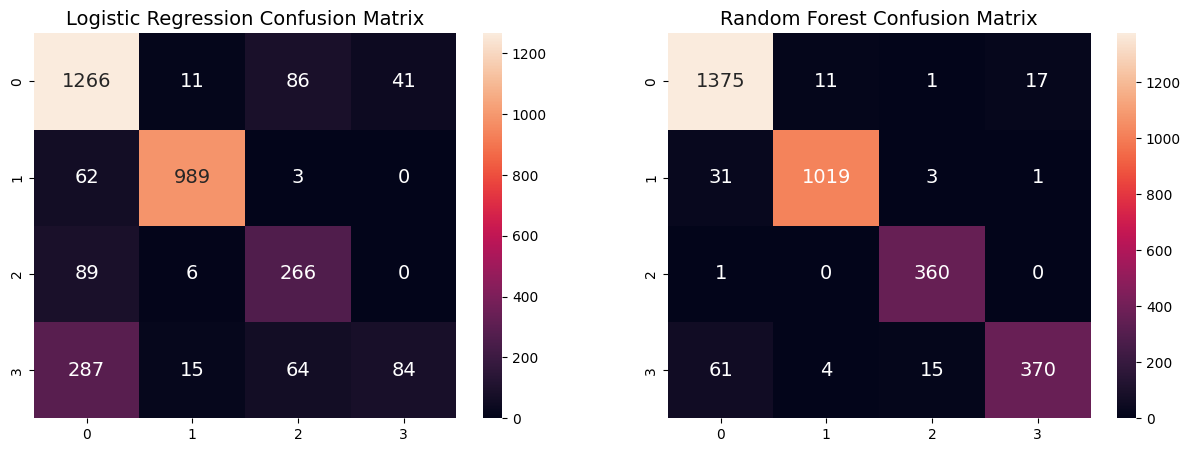

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


# Preprocessing
housing = housing.dropna()  # Drop missing values for simplicity
label_encoder = LabelEncoder()
housing['ocean_proximity'] = label_encoder.fit_transform(housing['ocean_proximity'])

# Define features and target
X = housing.drop('ocean_proximity', axis=1)
y = housing['ocean_proximity']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression model
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_test_scaled)

# Random Forest model
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

# Evaluate the models
print("Logistic Regression:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg)}")
print(confusion_matrix(y_test, y_pred_log_reg))
print(classification_report(y_test, y_pred_log_reg))

print("\nRandom Forest:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.heatmap(confusion_matrix(y_test, y_pred_log_reg), annot=True, fmt='d', ax=axes[0])
axes[0].set_title('Logistic Regression Confusion Matrix')

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', ax=axes[1])
axes[1].set_title('Random Forest Confusion Matrix')

plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


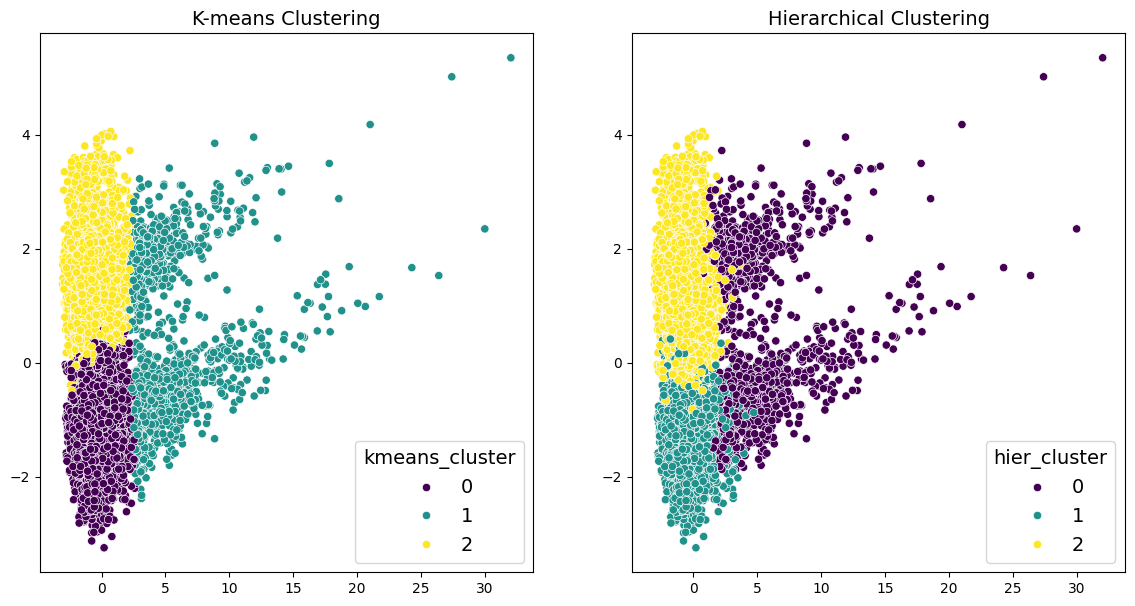

K-means Clustering Cluster Means:
                 longitude   latitude  housing_median_age  total_rooms  \
kmeans_cluster                                                           
0              -118.005181  33.915262           29.700925  2170.429785   
1              -119.176671  35.259802           16.698204  7816.900000   
2              -121.682373  37.938487           29.688135  2181.902045   

                total_bedrooms   population   households  median_income  \
kmeans_cluster                                                            
0                   455.192054  1268.915912   426.457531       3.909677   
1                  1565.887425  3973.581437  1429.673653       4.236554   
2                   434.928615  1106.235705   403.896780       3.746476   

                median_house_value  ocean_proximity  hier_cluster  
kmeans_cluster                                                     
0                    214561.273216         0.828237      1.035957  
1              

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns



housing = load_housing_data()

# Preprocessing
housing = housing.dropna()  # Drop missing values for simplicity
label_encoder = LabelEncoder()
housing['ocean_proximity'] = label_encoder.fit_transform(housing['ocean_proximity'])

# Define features
X = housing.drop('ocean_proximity', axis=1)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
housing['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

# Hierarchical clustering
hier_clust = AgglomerativeClustering(n_clusters=3)
housing['hier_cluster'] = hier_clust.fit_predict(X_scaled)

# Reduce dimensions for visualization using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot K-means clustering results
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=housing['kmeans_cluster'], palette='viridis')
plt.title('K-means Clustering')

# Plot Hierarchical clustering results
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=housing['hier_cluster'], palette='viridis')
plt.title('Hierarchical Clustering')

plt.show()

# Profiling Clusters
print("K-means Clustering Cluster Means:")
print(housing.groupby('kmeans_cluster').mean())

print("\nHierarchical Clustering Cluster Means:")
print(housing.groupby('hier_cluster').mean())


Both clustering methods reveal clusters with different characteristics in terms of location, housing age, and income levels.
K-means clusters show a clear differentiation based on housing age and median income, while hierarchical clusters show similar patterns but slightly different groupings.
Cluster profiling indicates geographical and socioeconomic diversity within the housing dataset.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import numpy as np



# Preprocessing
housing = housing.dropna()  # Drop missing values for simplicity
label_encoder = LabelEncoder()
housing['ocean_proximity'] = label_encoder.fit_transform(housing['ocean_proximity'])

# Define features and target
X = housing.drop('median_house_value', axis=1)
y = housing['median_house_value']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Elastic Net': ElasticNet(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'Support Vector Regressor': SVR(),
    'K-Nearest Neighbors': KNeighborsRegressor()
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[name] = rmse
    print(f'{name} RMSE: {rmse}')

# Display results in a DataFrame
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'RMSE'])
results_df = results_df.sort_values(by='RMSE')
results_df.reset_index(drop=True, inplace=True)
results_df


Linear Regression RMSE: 69688.9972825519
Ridge Regression RMSE: 69689.18840131655
Lasso Regression RMSE: 69688.9924242639
Elastic Net RMSE: 81879.70771652841
Decision Tree RMSE: 68629.65784406543
Random Forest RMSE: 49645.71358356721
Gradient Boosting RMSE: 55796.320942895654
AdaBoost RMSE: 95173.4356557944
Support Vector Regressor RMSE: 119506.47471337653
K-Nearest Neighbors RMSE: 60431.16708517987


,Model,RMSE
0,Random Forest,49645.713584
1,Gradient Boosting,55796.320943
2,K-Nearest Neighbors,60431.167085
3,Decision Tree,68629.657844
4,Lasso Regression,69688.992424
5,Linear Regression,69688.997283
6,Ridge Regression,69689.188401
7,Elastic Net,81879.707717
8,AdaBoost,95173.435656
9,Support Vector Regressor,119506.474713


<ipython-input-235-71fdbb384b5c>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RMSE', y='Model', data=results_df, palette='viridis')


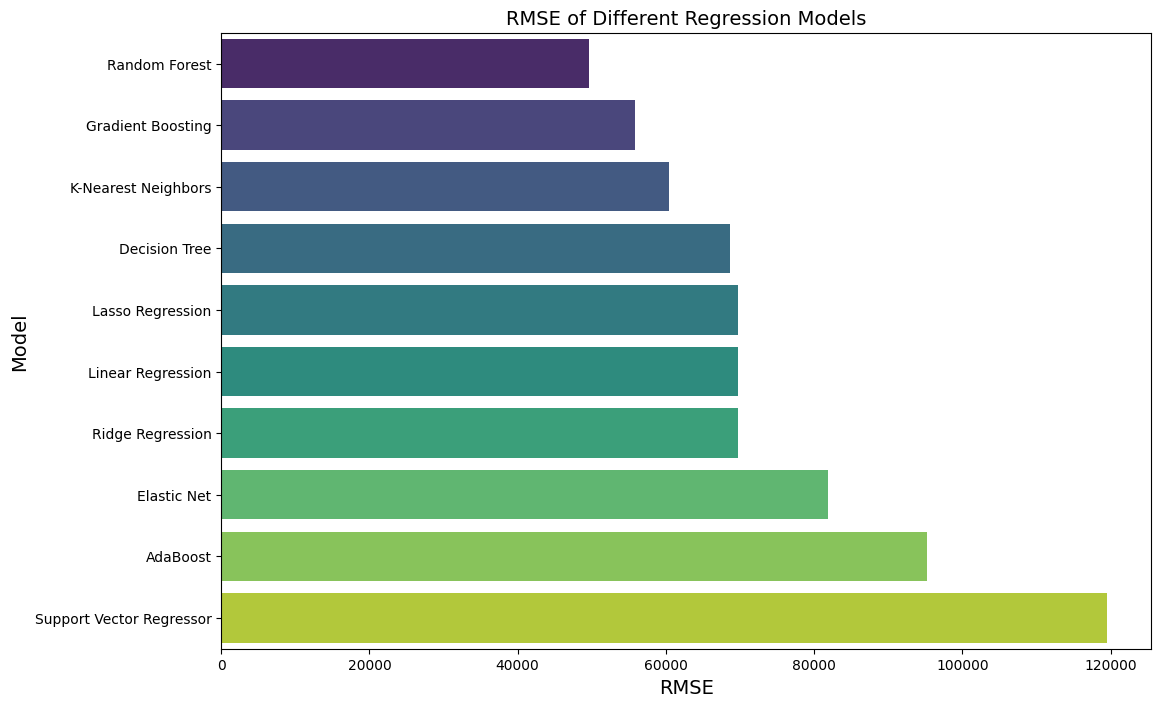

In [ ]:
import seaborn as sns

# Sort the results for better visualization
results_df = results_df.sort_values(by='RMSE')

# Plot the RMSE results using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='RMSE', y='Model', data=results_df, palette='viridis')
plt.xlabel('RMSE')
plt.title('RMSE of Different Regression Models')
plt.show()


Best Models: Random Forest and Gradient Boosting, with Random Forest being the most accurate.
Moderate Performance: K-Nearest Neighbors and Decision Tree.
Poor Performance: AdaBoost, Elastic Net, and Support Vector Regressor.
Linear Models: Linear, Ridge, and Lasso Regression performed similarly, with moderate RMSE values.